# Tensorflow load dataset

In [1]:
from  tensorflow.keras.utils import image_dataset_from_directory

2023-03-26 23:09:33.587546: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
images_train, images_test = image_dataset_from_directory(
                                                    directory = '../../data/Aug/',
                                                    batch_size=32,
                                                   labels = 'inferred',
                                                   label_mode='categorical',
#       class_names=['Angela','Dwight','Jim','Kevin','Michael','Pam'],
                                                    image_size = (96,96),
                                                    seed = 42,
                                                    validation_split = 0.2,
                                                    subset = 'both',
                                                     interpolation = 'area',
                                                     crop_to_aspect_ratio = True)

Found 17658 files belonging to 6 classes.
Using 14127 files for training.
Using 3531 files for validation.


In [16]:
class_names = images_train.class_names

In [17]:
class_names

['Angela', 'Dwight', 'Jim', 'Kevin', 'Michael', 'Pam']

# images output

In [5]:
import matplotlib.pyplot as plt
import numpy as np 

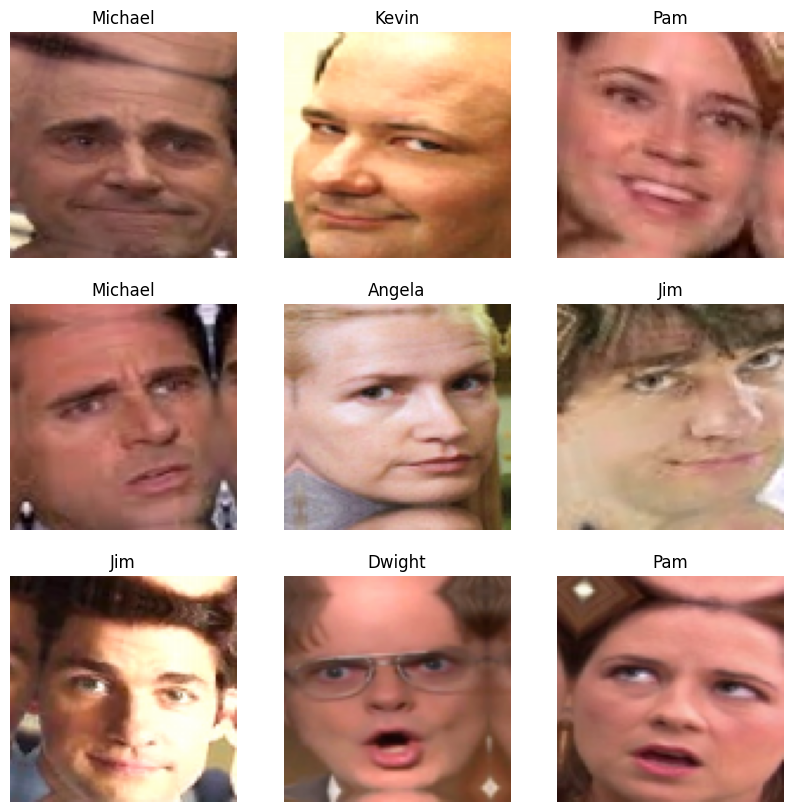

In [18]:
# Get one batch of images and labels

plt.figure(figsize=(10, 10))
for images, labels in images_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")


# Base-model

In [ ]:
!pip install -U efficientnet

In [9]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
# import efficientnet.keras as efn
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.optimizers.experimental import SGD
from tensorflow.keras.activations import gelu

In [20]:
base_model = ResNet152(input_shape = (96, 96, 3), include_top = False, weights = 'imagenet')

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained VGG16 model
model = Sequential([
    base_model,
    Flatten(),
    Dense(1536, activation='relu'),
    Dropout(0.15),
    Dense(512, activation='relu'),
    Dense(6, activation='softmax')
])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 3, 3, 2048)        58370944  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_3 (Dense)             (None, 1536)              28313088  
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 87,474,054
Trainable params: 29,103,110


In [21]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy']
             )

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy',patience = 10,restore_best_weights=True)

In [24]:
history = model.fit(images_train,
                  epochs = 100,batch_size=32,
               verbose=1, validation_data=images_test,
               callbacks = [es]
              )

Epoch 1/100
442/442 [==============================] - 794s 2s/step - loss: 0.9325 - accuracy: 0.9249 - val_loss: 0.1453 - val_accuracy: 0.9553
Epoch 2/100
442/442 [==============================] - 1117s 3s/step - loss: 0.0640 - accuracy: 0.9804 - val_loss: 0.1220 - val_accuracy: 0.9720
Epoch 3/100
442/442 [==============================] - 1681s 4s/step - loss: 0.0823 - accuracy: 0.9811 - val_loss: 0.0753 - val_accuracy: 0.9864
Epoch 4/100
257/442 [================>.............] - ETA: 10:03 - loss: 0.0509 - accuracy: 0.9881

In [13]:
# %tensorboard --logdir logs/fit

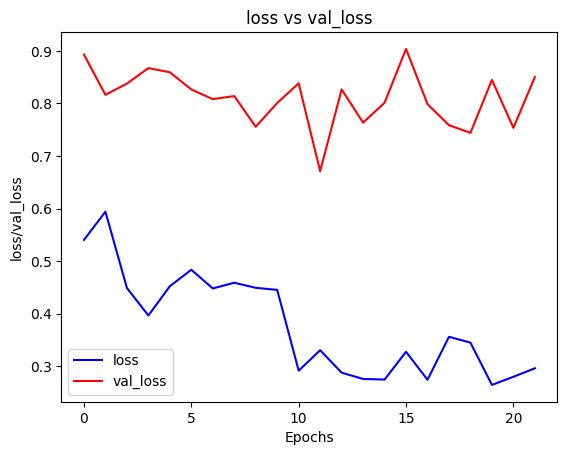

In [117]:
plt.plot(model.history.history['loss'],color='b',label='loss')
plt.plot(model.history.history['val_loss'],color='r',label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss/val_loss')
plt.title('loss vs val_loss')
plt.show()

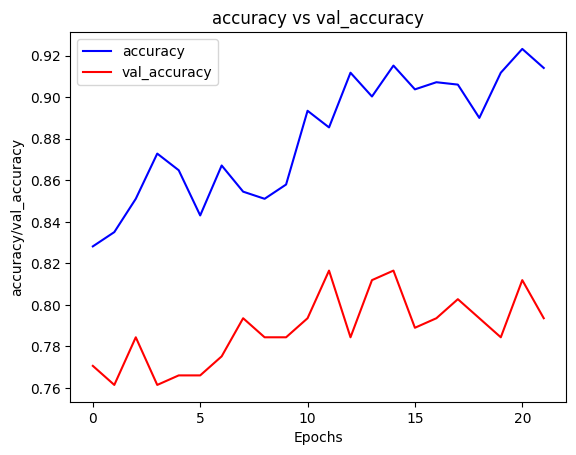

In [118]:
plt.plot(model.history.history['accuracy'],color='b',label = 'accuracy')
plt.plot(model.history.history['val_accuracy'],color='r',label = 'val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy/val_accuracy')
plt.title('accuracy vs val_accuracy')
plt.show()

# evaluate

In [119]:
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
import os 

In [120]:
img_paths = os.listdir("../../data/crop_Test1/")

In [107]:
label

['Dwight',
 'Jim',
 'Pam',
 'Jim',
 'Dwight',
 'Pam',
 'Kevin',
 'Jim',
 'Jim',
 'Dwight',
 'Pam',
 'Michael']

In [121]:
img_paths

['shutterstock_5886251dc_face0.png',
 'l-intro-1643218352_face0.png',
 'HaAszyPPvmTTPb27Gr9y2R_face0.png',
 '9050b6ca7dbea34b336b20d86e339f14_face0.png',
 'Dwight_Schrute_face0.png',
 'images1_face0.png',
 'images_face0.png',
 'intro-1617813480_face0.png',
 'q7CNBoaEvF4HHnuLuNukwe_face0.png',
 'hf7i5dTEg4HMKLiYutRShG_face0.png',
 'kevin-the-office-main-khu-210831_face0.png',
 'download_face0.png']

In [122]:
label = []
images = []
for img_path in img_paths:
    img = image.load_img(os.path.join("../../data/crop_Test1/",img_path),target_size=(96,96))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    label.append(class_names[np.argmax(prediction,axis=1)[0]])
    images.append(img)
    

1/1 [==============================] - 0s 183ms/step


In [109]:
images

[<PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>]

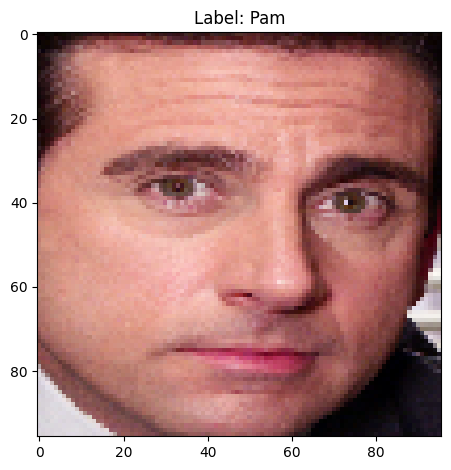

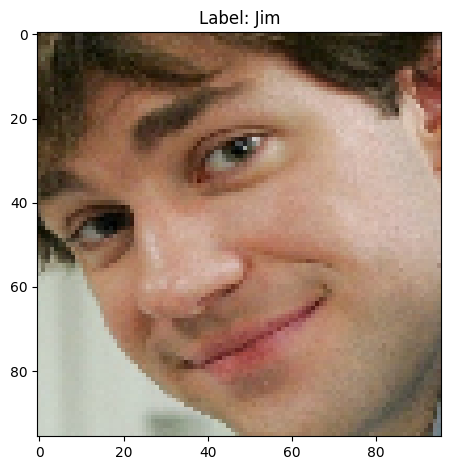

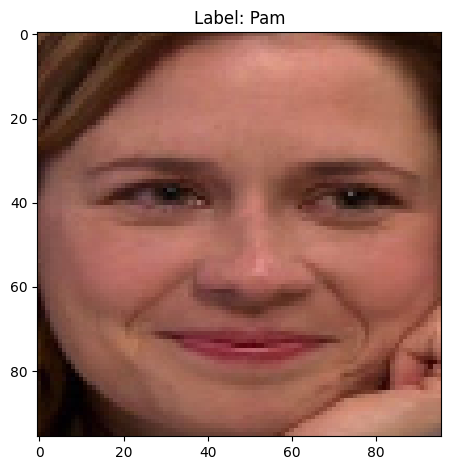

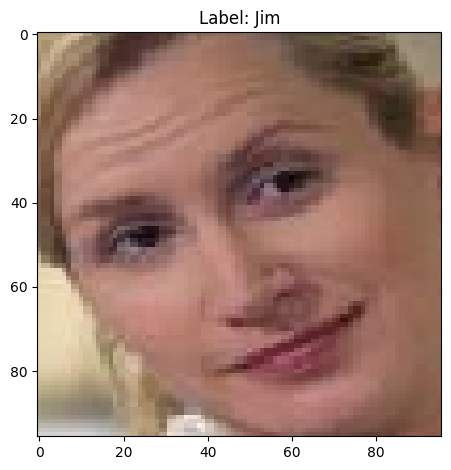

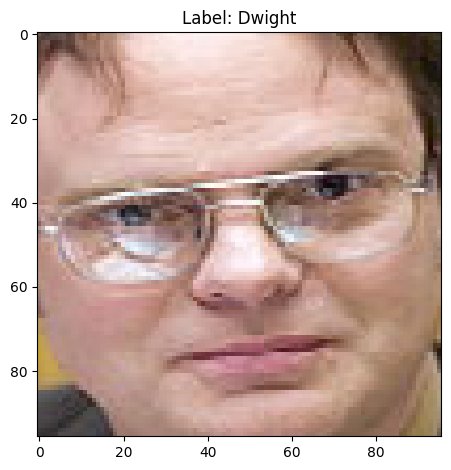

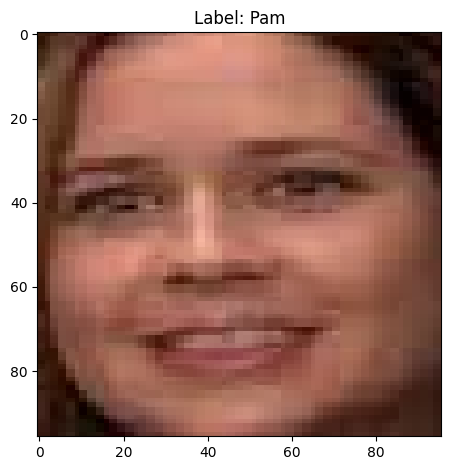

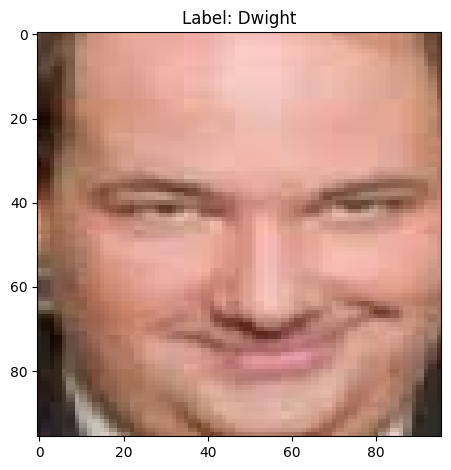

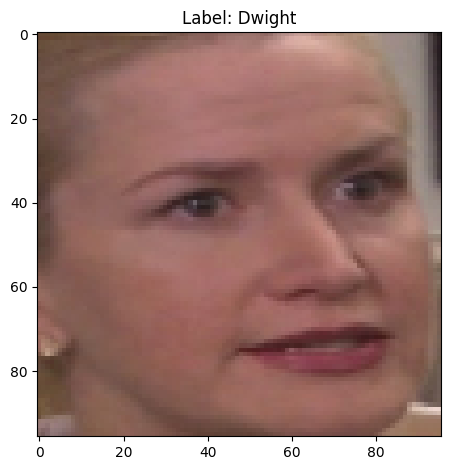

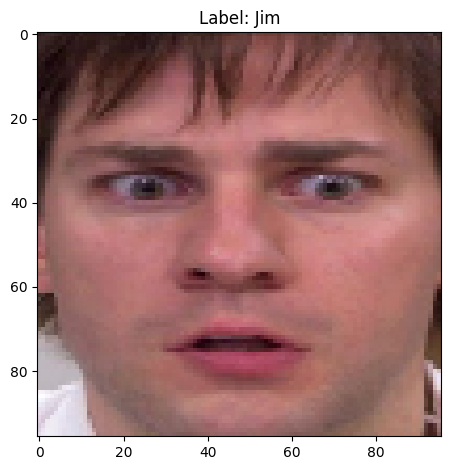

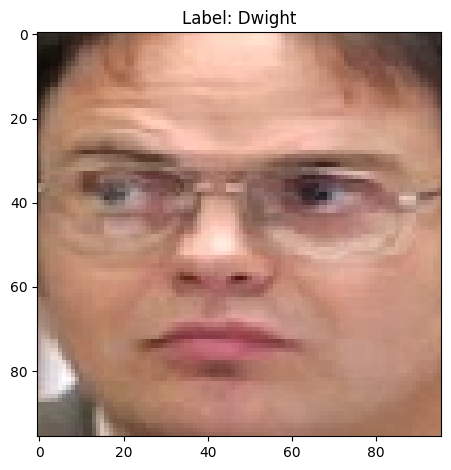

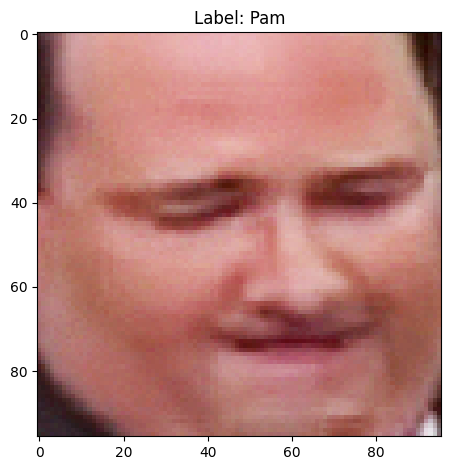

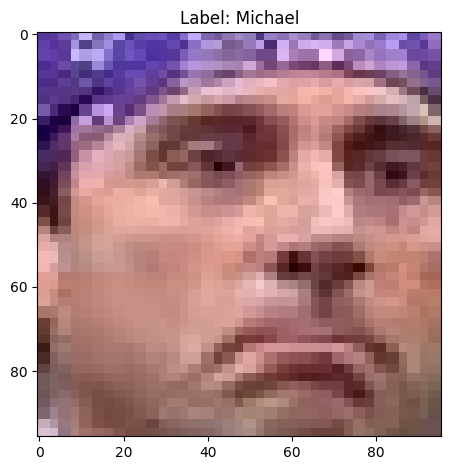

In [123]:
for idx,image in enumerate(images):
    # Plot the images
    plt.imshow(image)
    plt.title(f'Label: {label[idx]}')
    plt.tight_layout()
    plt.show()

In [98]:
prediction = model.predict(img_preprocessed)

1/1 [==============================] - 0s 218ms/step


'Dwight'

In [ ]:
# from mtcnn import MTCNN
# import cv2
# import os
# from glob import glob

In [ ]:
# folder_list = glob(os.path.join("../../raw_data/Kaggle_clean/", '*'))
# #print(filename_list)

# filename_list = []
# for folder in folder_list:
#     filename_list.append(glob(os.path.join(folder, "*.png")))


In [ ]:
# folder_list

In [ ]:
# def crop_faces(img, image, faces):
#     if len(faces) > 0:
#         for i, face in enumerate(faces):
#             x, y, w, h = face['box']
            
#             # get face and save crop
#             face = image[y:y + h, x:x + w]
#             face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
#             cv2.imwrite(f"{img[:-4].replace('Kaggle_clean', 'cropped')}_face{i}.png", face)
#             print(f"{img[:-4].replace('Kaggle_clean', 'cropped')}_face{i}.png is saved")
#     return None   

In [ ]:
# detector = MTCNN()

# for img_path in filename_list:
#     for i, img in enumerate(img_path):
#         image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
#         #Outputs a faces list of dict, with the bounding box inside the key 'box'
#         faces = detector.detect_faces(image)
#         crop_faces(img, image, faces)

In [48]:
# images_test_main = image_dataset_from_directory(
#                                                    directory = '../../data/crop_Test/Michael',
#                                                     labels = None,label_mode=None,
#                                                     image_size = (96,96),
#                                                     seed = 42,
#                                                     interpolation = 'bicubic',
#                                                     crop_to_aspect_ratio = True)

Found 5 files belonging to 1 classes.


In [ ]:
# for images in images_test_main.take(1):
#     # Plot the images
#     fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
#     for i, ax in enumerate(axes.flatten()):
#         ax.imshow(images[i].numpy().astype("uint8"))
#         ax.axis('off')
#         ax.set_title(f'Label: {labels[i]}')
#     plt.tight_layout()
#     plt.show()

In [24]:
model.evaluate(images_test
              )

7/7 [==============================] - 10s 1s/step - loss: 0.6066 - accuracy: 0.8532


[0.6065536737442017, 0.853210985660553]

In [1]:
result = model.predict(images_test)

NameError: name 'model' is not defined

In [26]:
result.shape

(12, 6)

In [50]:
import numpy as np
labels = np.argmax(result,axis=1)
labels 

array([4, 4, 4, 4, 2])

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 12 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

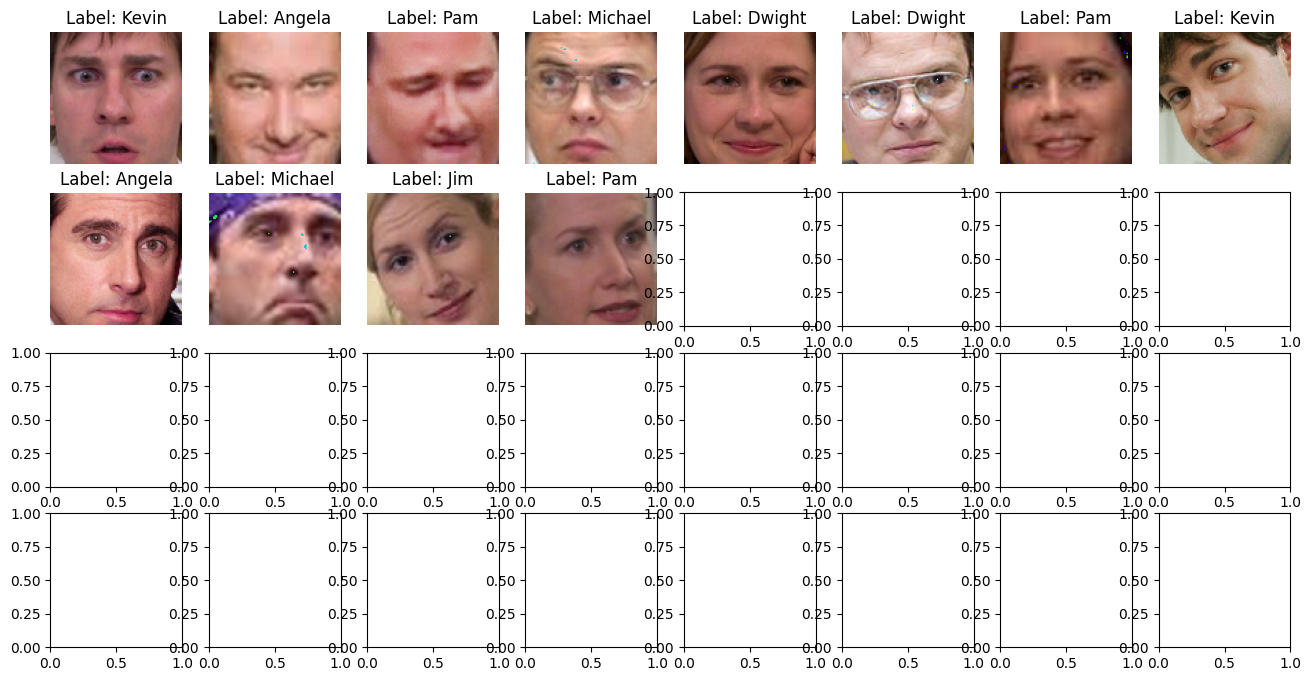

In [28]:
for images in images_test_main.take(1):
    # Plot the images
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis('off')
        ax.set_title(f'Label: {class_names[labels[i]]}')
    plt.tight_layout()
    plt.show()

In [3]:
from mtcnn import MTCNN
import cv2
import os
from glob import glob

In [4]:
img_path = '../../data/'
img_file = 'original.png'
img_type = img_file.split('.')[1]
image = cv2.cvtColor(cv2.imread(f'{img_path}{img_file}'), cv2.COLOR_BGR2RGB)
#Outputs a faces list of dict, with the bounding box inside the key 'box'
detector = MTCNN()
faces = detector.detect_faces(image)

2/2 [==============================] - 0s 16ms/step


In [ ]:
if len(faces) > 0:
    for i, face in enumerate(faces):
        x, y, w, h = face['box']
        
        # get face and save crop
        face = image[y:y + h, x:x + w] 
        cv2.imwrite(f'{img_path}face{i}.{img_type}', face)
        print(f"face{i}.{img_type} is saved")    
        cv2.imshow("Cropped Face", face)